# **Importing Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
from random import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git 

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-kywglsbd
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-kywglsbd
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=1c949e69b7e11b94e354d877d055c37d8c05d4dfba4c444a94f17cd3ee82db3c
  Stored in directory: /tmp/pip-ephem-wheel-cache-8kd_cc53/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [ ]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

# **Generator and ResNet**

In [ ]:
#define generator
def generator(image_shape, num_resnet=9):
    #print("generator")
    model= Sequential()
    initializer= RandomNormal(stddev=0.05)
    input_image= Input(shape=image_shape)
    
    model.add(Conv2D(64,(7,7), padding="same", kernel_initializer=initializer, input_shape=image_shape))
    model.add(InstanceNormalization(axis=-1))
    model.add(Activation("relu"))
    
    model.add(Conv2D(128,(3,3),strides= (2,2), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(Activation("relu"))
    
    model.add(Conv2D(256,(3,3),strides= (2,2), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(Activation("relu"))
    
    for _ in range (num_resnet):
        resnet_block(256, model)
    
    model.add(Conv2DTranspose(128,(3,3), strides= (2,2), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(Activation("relu"))
    
    model.add(Conv2DTranspose(64,(3,3), strides= (2,2), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(Activation("relu"))

    model.add(Conv2D(3,(7,7), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(Activation("tanh"))
    
    return model
    

In [ ]:
#ResNet
def resnet_block (num_filters, input_layer):
    #print("resnet")
    initializer=RandomNormal(stddev=0.05)
    model= Sequential()
    
    model.add(Conv2D(num_filters,(3,3), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(Activation("relu"))
    
    model.add(Conv2D(num_filters,(3,3), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(Activation("relu"))
    
    return model
    

# **Discriminator**

In [ ]:
#Discriminator
def discriminator (image_shape):
    #print("discriminator")
    model= Sequential()
    initializer= RandomNormal(stddev=0.05)
    input_image= Input(shape=image_shape)
    
    model.add(Conv2D(64,(4,4), strides=(2,2), padding="same", kernel_initializer=initializer, input_shape= image_shape))
    model.add(LeakyReLU(alpha=0.2))
              
    model.add(Conv2D(128,(4,4), strides=(2,2), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256,(4,4), strides=(2,2), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(512,(4,4), strides=(2,2), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(LeakyReLU(alpha=0.2))
    
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
              
    return model


# **Loss functions**

In [ ]:
#Combine generator and discriminator blocks
def composite_model (generator_1, discriminator, generator_2, image_shape):
    #print("composite")
    generator_1.trainable= True
    discriminator.trainable= False
    generator_2.trainable= False
    
    #adversarial loss
    input_gen= Input(shape=image_shape)
    gen1_out= generator_1(input_gen)
    output_d= discriminator(gen1_out)
    
    #identity loss
    input_id= Input(shape=image_shape)
    output_id= generator_1(input_id)
    
    #cycle loss- forward
    output_f= generator_2(gen1_out)
    
    #cycle loss- backward
    gen2_out= generator_2(input_id)
    output_b= generator_1(gen2_out)
    
    model= Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    
    opt= Adam(learning_rate=0.0002, beta_1=0.5)
    
    model.compile(loss=["mse", "mae", "mae", "mae"],
                  loss_weights=[1,5,10,10],
                  optimizer=opt)
    
    return model    

# **Generating fake samples**

In [ ]:
def generate_fake_samples(generator, dataset, patch_shape):
    #print("generate fake samples")
    X= generator.predict(dataset)
    y= np.zeros((len(X), patch_shape, patch_shape, 1))

    return X,y

# **Updating the image pool with generated samples**

In [ ]:
def update_image_pool(pool, images, max_size=50):
    #print("update image pool")
    selected =[]
    for image in images:
        if len(pool) < max_size:

            pool.append(image)
            selected.append(image)

        elif random() < 0.5:
            selected.append(image)

        else:
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image

    return np.asarray(selected)

# **Generating real samples**

In [ ]:
def generate_real_samples(dataset, num_samples, patch_shape):
    #print("generate real samples")
    ix = np.random.randint(0, dataset.shape[0], num_samples)
    X = dataset[ix]
    y = np.ones((num_samples, patch_shape, patch_shape, 1))

    return X,y

# **Saving the model**

In [ ]:
def save_models(step, generator_AtoB, generator_BtoA):
    #print("save models")
    filename1 = 'generator_AtoB_%06d.h5' % (step+1)
    generator_AtoB.save(filename1)

    filename2 = 'generator_BtoA_%06d.h5' % (step+1)
    generator_BtoA.save(filename2)
    print("Saved generators to disk")

# **Saving the photos (plot)**

In [ ]:
# save photos generated
def plot_real_translated(step, generator, trainX, name, num_samples=5):
    #print("plot real translated")
    
    X_in, _ = generate_real_samples(trainX, num_samples, 0)
  
    X_out, _ = generate_fake_samples(generator, X_in, 0)
  
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    # plot real images
    for i in range(num_samples):
        plt.subplot(2, num_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_in[i])
    # plot translated image
    for i in range(num_samples):
        plt.subplot(2, num_samples, 1 + num_samples + i)
        plt.axis('off')
        plt.imshow(X_out[i])
    # save plot to file
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    plt.savefig(filename1)
    plt.close()

# **Training**

In [ ]:
def train (discriminator_A, discriminator_B, generator_AtoB, generator_BtoA, composite_AtoB, composite_BtoA, dataset, epochs=10):

    num_epochs, num_batch= epochs, 1
    num_patch = discriminator_A.output_shape[1]
    
    num_patch = discriminator_A.output_shape[1]
    
    trainA, trainB = dataset
    
    poolA, poolB= [], []
    
    batch_per_epochs = int(len(trainA)/num_batch)
    
    num_steps= batch_per_epochs* num_epochs
    
    for i in range (num_steps):
        X_realA, y_realA = generate_real_samples(trainA, num_batch, num_patch)
        X_realB, y_realB = generate_real_samples(trainB, num_batch, num_patch)        
        
        X_fakeA, y_fakeA = generate_fake_samples(generator_BtoA, X_realB, num_patch)
        X_fakeB, y_fakeB = generate_fake_samples(generator_AtoB, X_realA, num_patch)        
        
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        
       
        g_loss2, _, _, _, _  = composite_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])

        dA_loss1 = discriminator_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = discriminator_A.train_on_batch(X_fakeA, y_fakeA)
        
        
        g_loss1, _, _, _, _ = composite_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])

       
        dB_loss1 = discriminator_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = discriminator_B.train_on_batch(X_fakeB, y_fakeB)
        
        if i%100==0:
            print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
            
        if (i+1) % (batch_per_epochs * 1) == 0:
            plot_real_translated(i, generator_AtoB, trainA, 'AtoB')
            plot_real_translated(i, generator_BtoA, trainB, 'BtoA')

        if (i+1) % (batch_per_epochs * 5) == 0:
            save_models(i, generator_AtoB, generator_BtoA)    
        
    

# **CycleGAN  Painting to Photo**


In [ ]:
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample

In [ ]:
#path of dataset
path= "/content/drive/MyDrive/vangogh2photo/vangogh2photo/"
#path= "/content/drive/MyDrive/PESU/TDL/vangogh2photo/vangogh2photo/"

# **Loading the data**

In [ ]:
#loading images
def load_images(path, size=(256,256)):
    #print("load images")
    data_list= []
    
    for filename in listdir(path):
        pixels= load_img(path + filename, target_size=size)
        gray = cv2.cvtColor(np.float32(pixels), cv2.COLOR_RGB2GRAY)
        img2 = np.zeros_like(pixels)
        img2[:,:,0] = gray
        img2[:,:,1] = gray
        img2[:,:,2] = gray
        pixels= img_to_array(img2)
        pixels= img_to_array(pixels)
        data_list.append(pixels)

    return asarray(data_list)

In [ ]:
#loading images
def load_images2(path, size=(256,256)):
    #print("load images")
    data_list= []
    
    for filename in listdir(path):

        pixels= load_img(path + filename, target_size=size)
        pixels= img_to_array(pixels)
        data_list.append(pixels)

    return asarray(data_list)

In [ ]:
# load dataset A - Paintings
import cv2
dataA_all = load_images(path +"trainA/")
print("loaded dataA: ",dataA_all.shape)


loaded dataA:  (400, 256, 256, 3)


In [ ]:
dataA= resample(dataA_all,
                replace=False,
                n_samples=400,
                random_state=10)

In [ ]:
# load dataset B - Photos 
dataB_all= load_images2(path+"trainB/trainB/")
print("loaded dataB: ", dataB_all.shape)



loaded dataB:  (400, 256, 256, 3)


In [ ]:
dataB= resample(dataB_all,
                replace=False,
                n_samples=400,
                random_state=10)

# **Plotting samples from the dataset**

In [ ]:
def samples_plot (num_samples):
    plt.figure(figsize=(num_samples+12,num_samples+7))

    for i in range (num_samples):
        plt.subplot(2,num_samples, 1+i)
        plt.axis("off")
        plt.imshow(dataA[np.random.randint(1,400)].astype('uint8'))
        plt.title("Painting")
        
    for i in range(num_samples):
        plt.subplot(2, num_samples, 1 + num_samples + i)
        plt.axis("off")
        plt.imshow(dataB[np.random.randint(1,400)].astype('uint8'))
        plt.title("Photo")
        
    plt.show()

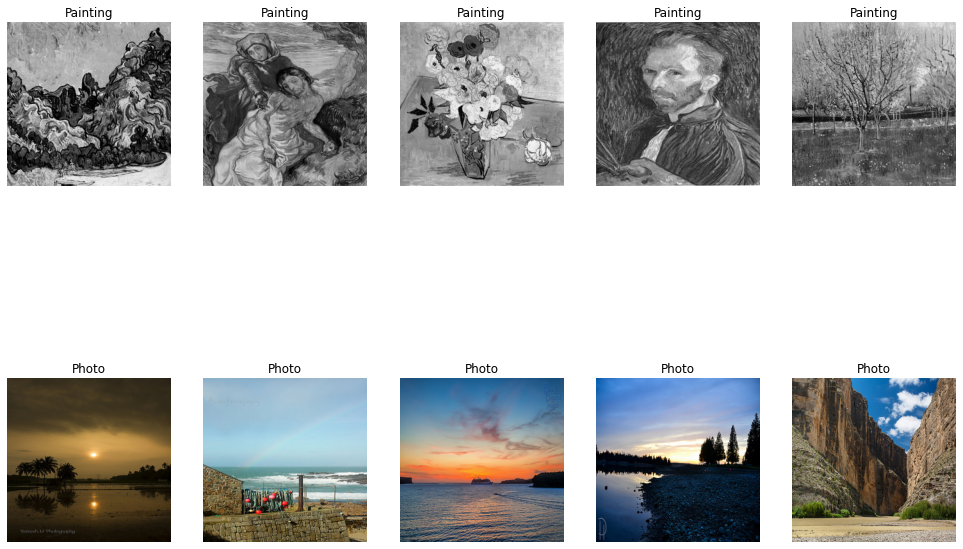

In [ ]:
samples_plot(5)

In [ ]:
data= [dataA, dataB]
print("loaded", data[0].shape, data[1].shape)

loaded (400, 256, 256, 3) (400, 256, 256, 3)


# **Preprocessing the data**

In [ ]:
def preprocess_data(data):
    #print("preprocess")
    X1, X2= data[0], data[1]
    
    X1= (X1-127.5) /127.5
    X2= (X2-127.5) /127.5
    
    return [X1,X2]

In [ ]:
dataset= preprocess_data(data)

In [ ]:
image_shape= dataset[0].shape[1:]
print("image shape: ",image_shape)

image shape:  (256, 256, 3)


# **The CycleGAN model**

In [ ]:
#create cycleGAN model
generator_AtoB = generator(image_shape)
generator_BtoA = generator(image_shape)

discriminator_A = discriminator(image_shape)
discriminator_B = discriminator(image_shape)

composite_AtoB= composite_model(generator_AtoB, discriminator_B, generator_BtoA, image_shape)
composite_BtoA= composite_model(generator_BtoA, discriminator_A, generator_AtoB, image_shape)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# **Training the CycleGAN**

In [ ]:
#Train the model with the paintings dataset
from datetime import datetime

start1= datetime.now()

train(discriminator_A, discriminator_B, generator_AtoB, generator_BtoA, composite_AtoB, composite_BtoA, dataset, epochs=10)

stop1= datetime.now()

execution_time= stop1-start1

print("Execution time is: ", execution_time )

Iteration>1, dA[0.444,0.262] dB[0.485,0.261] g[19.099,18.409]
Iteration>101, dA[0.331,0.088] dB[0.327,0.083] g[7.255,7.368]
Iteration>201, dA[0.330,0.047] dB[0.320,0.081] g[6.566,7.612]
Iteration>301, dA[0.327,0.077] dB[0.313,0.100] g[7.205,7.473]
Iteration>401, dA[0.324,0.069] dB[0.310,0.093] g[5.705,5.144]
Iteration>501, dA[0.314,0.083] dB[0.295,0.073] g[8.546,7.211]
Iteration>601, dA[0.306,0.065] dB[0.298,0.080] g[5.307,4.907]
Iteration>701, dA[0.303,0.090] dB[0.317,0.092] g[4.783,5.355]
Iteration>801, dA[0.295,0.084] dB[0.296,0.072] g[5.144,5.404]
Iteration>901, dA[0.295,0.068] dB[0.320,0.079] g[3.815,3.912]
Iteration>1001, dA[0.290,0.165] dB[0.318,0.100] g[6.672,5.440]
Iteration>1101, dA[0.285,0.071] dB[0.300,0.134] g[3.802,4.261]
Iteration>1201, dA[0.301,0.070] dB[0.275,0.073] g[4.279,4.121]
Iteration>1301, dA[0.282,0.049] dB[0.317,0.084] g[5.585,5.101]
Iteration>1401, dA[0.281,0.099] dB[0.284,0.078] g[4.943,5.109]
Iteration>1501, dA[0.276,0.084] dB[0.277,0.102] g[4.717,4.507]
It

In [ ]:
generator_AtoB.save('/content/drive/MyDrive/colorize')
generator_BtoA.save('/content/drive/MyDrive/colorize')
#generator_AtoB.save('/content/drive/MyDrive/PESU/TDL/vangogh2photo')
#generator_BtoA.save('/content/drive/MyDrive/PESU/TDL/vangogh2photo')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/colorize/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/colorize/assets


# **Visualizing**

In [ ]:
#choose random sample from dataset

from tensorflow.keras.models import load_model

def select_sample (dataset, num_samples):
    #print("select sample")
    ix= np.random.randint(0, dataset.shape[0], num_samples)
    X=dataset[ix]
    return X

In [ ]:
#display generated images on screen
def show_plot(imagesX, imagesY1, imagesY2):
    #print("show plot")
    images = vstack((imagesX, imagesY1, imagesY2))
    titles = ['Real', 'Generated', 'Reconstructed']
    images = (images + 1) / 2.0
    plt.figure(figsize=(15,10))

    for i in range(len(images)):
        plt.subplot(1, len(images), 1 + i)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    plt.show()

In [ ]:
# load dataset
A_data = resample(dataA_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=10) # reproducible results

B_data = resample(dataB_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=10) # reproducible results

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5

In [ ]:
# load the models

cust= {"InstanceNormalization" : InstanceNormalization}
#model_AtoB= load_model("generator_AtoB_005000.h5", cust)
#model_BtoA= load_model("generatorl_BtoA_005000.h5", cust)

#model_AtoB= generator_AtoB
#model_BtoA= generator_BtoA

model_AtoB= load_model("/content/drive/MyDrive/colorize", cust)
model_BtoA= load_model("/content/drive/MyDrive/colorize", cust)
# model_AtoB= load_model("/content/drive/MyDrive/PESU/TDL/vangogh2photoA", cust)
# model_BtoA= load_model("/content/drive/MyDrive/PESU/TDL/vangogh2photoB", cust)
#model_AtoB= load_model("/content/drive/MyDrive/PESU/TDL/vangogh2photo", cust)
#model_BtoA= load_model("/content/drive/MyDrive/PESU/TDL/vangogh2photo", cust)

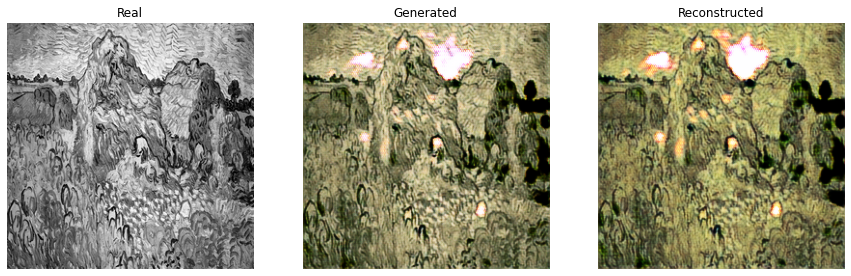

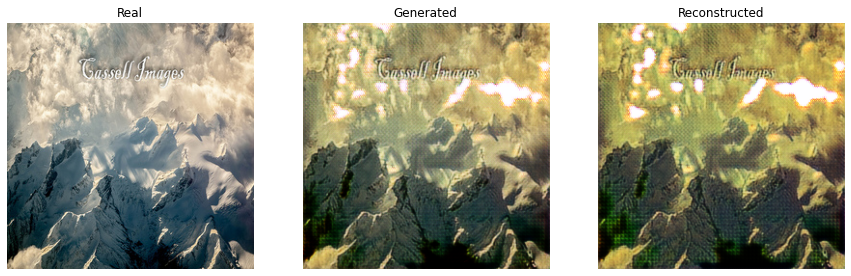

In [ ]:
# plot A -> B -> A (painting to photo to painting)

A_real= select_sample(A_data,1)    
B_generated = model_AtoB .predict(A_real)
A_reconstructed= model_BtoA.predict(B_generated)   

show_plot(A_real, B_generated, A_reconstructed)


# plot B -> A -> B (photo to painting to photo)

B_real= select_sample(B_data,1)
A_generated= model_BtoA.predict(B_real)
B_reconstructed= model_AtoB.predict(A_generated)

show_plot(B_real, A_generated, B_reconstructed)

## **Test Images**

In [ ]:
#test1='/content/drive/MyDrive/vangogh2photo/convert.jpeg'
#test1='/content/drive/MyDrive/PESU/TDL/vangogh2photo/vangogh2photo/convert.jpeg'
test1= '/content/teest.jpeg'

In [ ]:
def test_model(test_image_path):
    #print("test model")
    #Load a single custom image
    test_image = load_img(test_image_path, target_size=(256,256))
    test_image = img_to_array(test_image)
    test_image_input = np.array([test_image])  # Convert single image to a batch.
    test_image_input = (test_image_input - 127.5) / 127.5
    
    # plot B->A->B (Photo to Painting to Photo)
    painting_generated  = model_BtoA.predict(test_image_input)
    photo_reconstructed = model_AtoB.predict(painting_generated)
    show_plot(test_image_input, painting_generated, photo_reconstructed)
    

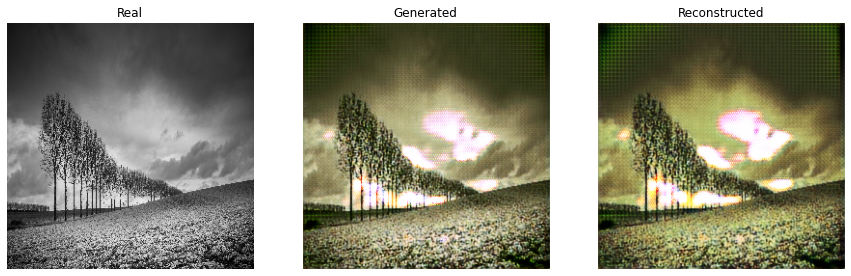

In [ ]:
test_model(test1)